In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error voxels
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [47]:
rand_8g_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 8))

In [48]:
rand_8g_bval_indice_100206

array([ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255])

In [49]:
bvals_100206_8g = bvals_all_100206[rand_8g_bval_indice_100206]*1e-3

In [50]:
normalized_scan_100206_8g = normalized_scan_100206_full[:, rand_8g_bval_indice_100206]

In [51]:
big_b_indice_100206_8g = np.where(bvals_100206_8g != 0.005)[0]

In [52]:
big_b_indice_100206_8g

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127])

In [53]:
bvals_100206_8g_no_b5 = bvals_100206_8g[big_b_indice_100206_8g]

In [54]:
normalized_scan_100206_8g_no_b5 = normalized_scan_100206_8g[:, big_b_indice_100206_8g]

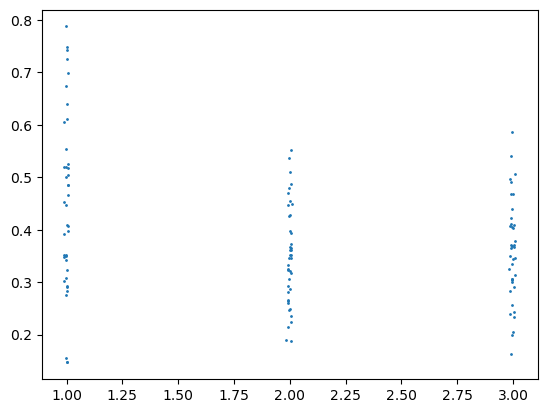

In [55]:
plt.plot(bvals_100206_8g_no_b5, normalized_scan_100206_8g_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [56]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_8g = n_100206_all[:, rand_8g_bval_indice_100206]

In [57]:
print(n_100206_8g.shape)
print(big_b_indice_100206_8g)

(3, 128)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127]


In [58]:
n_100206_8g_no_b5 = n_100206_8g[:,big_b_indice_100206_8g].T
print(n_100206_8g_no_b5.shape)

b_values_100206_8g_no_b5 = torch.FloatTensor(bvals_100206_8g_no_b5)
gradient_directions_100206_8g_no_b5 = torch.FloatTensor(n_100206_8g_no_b5)

net = BallStickNet(gradient_directions_100206_8g_no_b5, b_values_100206_8g_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(120, 3)


In [59]:
batch_size = 128
num_batches = len(normalized_scan_100206_8g_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_8g_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [60]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.79it/s]


Loss: 518.450832686387
Average Loss: 0.07094291635008032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.06it/s]


Loss: 416.66663532098755
Average Loss: 0.057015138932811654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.34it/s]


Loss: 413.8690468859859
Average Loss: 0.05663232716009659
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.71it/s]


Loss: 412.8690927885473
Average Loss: 0.056495497097502366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.22it/s]


Loss: 411.84703336237
Average Loss: 0.05635564222254652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.29it/s]


Loss: 411.4101456434
Average Loss: 0.05629586010446087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.19it/s]


Loss: 411.155411824584
Average Loss: 0.05626100326006896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.02it/s]


Loss: 410.9244901128113
Average Loss: 0.05622940477734145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.89it/s]


Loss: 409.6825294198934
Average Loss: 0.05605945941706259
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.63it/s]


Loss: 409.6877128202468
Average Loss: 0.056060168694615053
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|███▍                                                                                                                                                          | 158/7308 [00:02<00:39, 179.83it/s]

X_batch: 
torch.Size([128, 120])
tensor([[0.2134, 0.3648, 0.2233,  ..., 0.3707, 0.1984, 0.2842],
        [0.1155, 0.2652, 0.1918,  ..., 0.2842, 0.1692, 0.3225],
        [0.1873, 0.5486, 0.3414,  ..., 0.5198, 0.2461, 0.1780],
        ...,
        [0.0833, 0.4490, 0.2049,  ..., 0.2459, 0.1237, 0.2656],
        [0.1981, 0.4744, 0.3059,  ..., 0.4536, 0.1771, 0.4154],
        [0.0567, 0.2487, 0.0813,  ..., 0.2095, 0.0704, 0.1117]])
X_pred: 
torch.Size([128, 120])
tensor([[0.1896, 0.4012, 0.2490,  ..., 0.3879, 0.1859, 0.2518],
        [0.1775, 0.3215, 0.2145,  ..., 0.3092, 0.1734, 0.2165],
        [0.1978, 0.5334, 0.3131,  ..., 0.5241, 0.1970, 0.3165],
        ...,
        [0.1580, 0.3722, 0.2139,  ..., 0.3611, 0.1556, 0.2165],
        [0.2438, 0.5096, 0.3279,  ..., 0.4930, 0.2478, 0.3339],
        [0.0749, 0.2274, 0.1026,  ..., 0.2216, 0.0735, 0.1038]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.60it/s]


Loss: 408.9514243947342
Average Loss: 0.05595941767853506
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.58it/s]


Loss: 408.7830298617482
Average Loss: 0.055936375186336644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.06it/s]


Loss: 408.43246183265
Average Loss: 0.0558884047390052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.02it/s]


Loss: 408.5609061541036
Average Loss: 0.05590598059032616
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.62it/s]


Loss: 407.99213419063017
Average Loss: 0.05582815191442668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.86it/s]


Loss: 408.39929642691277
Average Loss: 0.0558838665061457
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.11it/s]


Loss: 407.91118087014183
Average Loss: 0.05581707455803802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.66it/s]


Loss: 408.08720250055194
Average Loss: 0.05584116071436124
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.45it/s]


Loss: 407.7201972082257
Average Loss: 0.0557909410520287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.71it/s]


Loss: 407.71916149999015
Average Loss: 0.05579079932950057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.34it/s]


Loss: 407.0906873391941
Average Loss: 0.05570480122320664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.81it/s]


Loss: 406.86694087670185
Average Loss: 0.05567418457535603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.37it/s]


Loss: 407.3909426147584
Average Loss: 0.055745887057301366
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.14it/s]


Loss: 406.7794752898626
Average Loss: 0.05566221610425049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.92it/s]


Loss: 406.72689424525015
Average Loss: 0.05565502110635607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.34it/s]


Loss: 406.79668012517504
Average Loss: 0.05566457035100918
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.25it/s]


Loss: 406.6252072376665
Average Loss: 0.05564110662803318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.01it/s]


Loss: 406.6060901687015
Average Loss: 0.05563849071821312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.84it/s]


Loss: 406.4772278852761
Average Loss: 0.055620857674504115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.41it/s]


Loss: 406.07830596598797
Average Loss: 0.05556627065763382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.20it/s]


Loss: 406.1142741346266
Average Loss: 0.0555711924103211
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.98it/s]


Loss: 406.24340815423056
Average Loss: 0.05558886263741524
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.37it/s]


Loss: 406.09478559345007
Average Loss: 0.05556852566960182
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.12it/s]


Loss: 405.63893910543993
Average Loss: 0.055506149302879025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.63it/s]


Loss: 405.8745692060329
Average Loss: 0.055538392064317585
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.70it/s]


Loss: 405.7566894874908
Average Loss: 0.05552226183463202
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.77it/s]


Loss: 405.9408173887059
Average Loss: 0.055547457223413504
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.11it/s]


Loss: 405.5087378665339
Average Loss: 0.055488333041397636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.18it/s]


Loss: 405.739750883542
Average Loss: 0.05551994401799973
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.16it/s]


Loss: 405.49854471185245
Average Loss: 0.05548693824737992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.30it/s]


Loss: 405.11026171874255
Average Loss: 0.0554338070222691
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.38it/s]


Loss: 403.7243817488197
Average Loss: 0.0552441682743322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.83it/s]


Loss: 403.2396679276135
Average Loss: 0.05517784180728154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.36it/s]


Loss: 402.9884905591607
Average Loss: 0.05514347161455401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.04it/s]


Loss: 402.1899415841326
Average Loss: 0.05503420109251952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.45it/s]


Loss: 402.2499524955638
Average Loss: 0.05504241276622383
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.58it/s]


Loss: 401.7989750416018
Average Loss: 0.05498070266031771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.23it/s]


Loss: 401.47772885719314
Average Loss: 0.05493674450700508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.11it/s]


Loss: 401.70153217506595
Average Loss: 0.05496736893473809
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.66it/s]


Loss: 401.15292475768365
Average Loss: 0.05489229950159875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.00it/s]


Loss: 401.24416849482805
Average Loss: 0.054904784960978115
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.00it/s]


Loss: 400.8005106563214
Average Loss: 0.054844076444488424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.99it/s]


Loss: 400.3268708388787
Average Loss: 0.054779265303623245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.42it/s]


Loss: 400.3672373217996
Average Loss: 0.054784788905555507
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.76it/s]


Loss: 400.020314038964
Average Loss: 0.05473731719197646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.32it/s]


Loss: 399.87064830586314
Average Loss: 0.054716837480276836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.30it/s]


Loss: 399.93261983874254
Average Loss: 0.054725317438251576
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.09it/s]


Loss: 399.224814559333
Average Loss: 0.05462846395174234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.53it/s]


Loss: 398.88312092539854
Average Loss: 0.05458170784419794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.37it/s]


Loss: 399.16572874761187
Average Loss: 0.054620378865299926
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.40it/s]


Loss: 398.74460418871604
Average Loss: 0.05456275372040449
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.43it/s]


Loss: 398.5775553297717
Average Loss: 0.0545398953653218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.94it/s]


Loss: 398.409408463398
Average Loss: 0.05451688676291708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.66it/s]


Loss: 398.2977285059169
Average Loss: 0.05450160488586712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.89it/s]


Loss: 397.9750164251309
Average Loss: 0.05445744614465393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.26it/s]


Loss: 398.03875033254735
Average Loss: 0.054466167259516605
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.07it/s]


Loss: 397.67646253318526
Average Loss: 0.05441659312167286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.34it/s]


Loss: 397.5800278503448
Average Loss: 0.054403397352263926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.86it/s]


Loss: 397.21092731459066
Average Loss: 0.05435289098448148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.21it/s]


Loss: 397.0561179006472
Average Loss: 0.05433170743030203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.76it/s]


Loss: 397.0330571332015
Average Loss: 0.05432855187920108
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.39it/s]


Loss: 396.85668792412616
Average Loss: 0.05430441816148415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.71it/s]


Loss: 396.7860927255824
Average Loss: 0.054294758172630325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.14it/s]


Loss: 396.48917758325115
Average Loss: 0.05425412939015478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.79it/s]


Loss: 396.5113279125653
Average Loss: 0.054257160360230615
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.42it/s]


Loss: 396.4664577350486
Average Loss: 0.05425102048919658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.84it/s]


Loss: 396.05408130260184
Average Loss: 0.05419459240593895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.86it/s]


Loss: 396.1942057190463
Average Loss: 0.05421376651875291
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.29it/s]


Loss: 395.97918358282186
Average Loss: 0.05418434367581033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.36it/s]


Loss: 395.7158499278594
Average Loss: 0.05414831006128344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.92it/s]


Loss: 395.66718356637284
Average Loss: 0.05414165073431484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.08it/s]


Loss: 395.80315995705314
Average Loss: 0.054160257246449524
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.83it/s]


Loss: 395.6236464451067
Average Loss: 0.05413569327382413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.51it/s]


Loss: 395.46221177396365
Average Loss: 0.05411360314367319
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.84it/s]


Loss: 395.3664238646161
Average Loss: 0.05410049587638425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.63it/s]


Loss: 395.2133278225083
Average Loss: 0.05407954677374224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.01it/s]


Loss: 395.1994566814974
Average Loss: 0.054077648697522906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.87it/s]


Loss: 395.3240951646585
Average Loss: 0.05409470377184709
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.04it/s]


Loss: 395.13780532963574
Average Loss: 0.054069212551947965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.90it/s]


Loss: 395.08724854304455
Average Loss: 0.054062294546119945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.61it/s]


Loss: 394.8670399254188
Average Loss: 0.05403216200402556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.95it/s]


Loss: 394.86481011193246
Average Loss: 0.054031856884500885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.26it/s]


Loss: 394.8707478668075
Average Loss: 0.054032669385167965
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.86it/s]


Loss: 394.63461862527765
Average Loss: 0.0540003583231086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.60it/s]


Loss: 394.6476041106507
Average Loss: 0.054002135209448646
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.99it/s]


Loss: 394.57014416879974
Average Loss: 0.053991535874219995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.53it/s]


Loss: 394.6727463239804
Average Loss: 0.054005575577994035
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.27it/s]


Loss: 394.40181724284776
Average Loss: 0.05396850263312093
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.28it/s]


Loss: 394.44784178375266
Average Loss: 0.05397480046302034
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.19it/s]


Loss: 394.297838233877
Average Loss: 0.0539542745257084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.06it/s]


Loss: 394.3652613393497
Average Loss: 0.0539635004569444
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.86it/s]


Loss: 394.21938873571344
Average Loss: 0.05394353978321202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.93it/s]


Loss: 394.34546734485775
Average Loss: 0.053960791919110254
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.34it/s]


Loss: 394.136056848336
Average Loss: 0.05393213695242693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.47it/s]


Loss: 394.2089041254949
Average Loss: 0.05394210510748425
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.44it/s]


Loss: 394.13583555072546
Average Loss: 0.053932106670871026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.77it/s]


Loss: 393.9218983699102
Average Loss: 0.05390283228925974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.27it/s]


Loss: 393.9054860412143
Average Loss: 0.05390058648620886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.50it/s]


Loss: 393.88834955892526
Average Loss: 0.053898241592627974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.83it/s]


Loss: 393.9450569259934
Average Loss: 0.0539060012214003
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.97it/s]


Loss: 394.07375078019686
Average Loss: 0.0539236112178704
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.75it/s]


Loss: 393.85239482996985
Average Loss: 0.05389332167897781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.14it/s]


Loss: 393.7501138069201
Average Loss: 0.05387932591775043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.37it/s]


Loss: 393.72351052844897
Average Loss: 0.05387568562239313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.05it/s]


Loss: 393.80127572012134
Average Loss: 0.05388632672689126
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.77it/s]


Loss: 393.6451370099094
Average Loss: 0.05386496127667069
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.85it/s]


Loss: 393.6033217490185
Average Loss: 0.05385923942925814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.16it/s]


Loss: 393.5295009710826
Average Loss: 0.05384913806391387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.49it/s]


Loss: 393.6509228802752
Average Loss: 0.05386575299401686
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.91it/s]


Loss: 393.5003032719251
Average Loss: 0.05384514275751575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.26it/s]


Loss: 393.4727811543271
Average Loss: 0.053841376731571855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.69it/s]


Loss: 393.6500362136867
Average Loss: 0.05386563166580278
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.63it/s]


Loss: 393.4054028778337
Average Loss: 0.05383215693456947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.07it/s]


Loss: 393.37504631932825
Average Loss: 0.05382800305409527
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.61it/s]


Loss: 393.47578755859286
Average Loss: 0.05384178811693936
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.57it/s]


Loss: 393.38098703254946
Average Loss: 0.053828815959571626
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.56it/s]


Loss: 393.38437534775585
Average Loss: 0.053829279604235884
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.17it/s]


Loss: 393.2677117458079
Average Loss: 0.05381331578349862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.15it/s]


Loss: 393.29253083933145
Average Loss: 0.05381671193751115
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.19it/s]


Loss: 393.36943497275934
Average Loss: 0.05382723521794736
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.07it/s]


Loss: 393.2764314264059
Average Loss: 0.053814508952710165
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.88it/s]


Loss: 393.28992382762954
Average Loss: 0.05381635520356179
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.26it/s]


Loss: 393.2526308319066
Average Loss: 0.05381125216638021
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.44it/s]


Loss: 393.09425015747547
Average Loss: 0.05378957993397311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.74it/s]


Loss: 393.1079904846847
Average Loss: 0.053791460110110115
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.32it/s]


Loss: 393.0666327942163
Average Loss: 0.053785800874961175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.53it/s]


Loss: 393.14980839844793
Average Loss: 0.05379718232053201
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.15it/s]


Loss: 393.22793229855597
Average Loss: 0.05380787250938095
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.53it/s]


Loss: 393.1313183067832
Average Loss: 0.05379465220399333
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.49it/s]


Loss: 393.1234941764269
Average Loss: 0.05379358157860248
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.14it/s]


Loss: 393.06120413867757
Average Loss: 0.053785058037585876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.71it/s]


Loss: 393.0071181061212
Average Loss: 0.053777657102643844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.36it/s]


Loss: 393.1706470027566
Average Loss: 0.0538000337989541
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.16it/s]


Loss: 392.97520365798846
Average Loss: 0.0537732900462491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.72it/s]


Loss: 392.9434493344743
Average Loss: 0.05376894490072171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.25it/s]


Loss: 392.9629334108904
Average Loss: 0.05377161103049951
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.94it/s]


Loss: 392.9984025398735
Average Loss: 0.053776464496424946
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.84it/s]


Loss: 392.95752590638585
Average Loss: 0.053770871087354385
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.17it/s]


Loss: 392.9056345988065
Average Loss: 0.05376377047055371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.29it/s]


Loss: 392.893151256023
Average Loss: 0.053762062295569644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.55it/s]


Loss: 392.81577168637887
Average Loss: 0.05375147395817992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.21it/s]


Loss: 392.9483069218695
Average Loss: 0.05376960959522024
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.94it/s]


Loss: 392.85422095190734
Average Loss: 0.053756735215094054
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.62it/s]


Loss: 392.78095391066745
Average Loss: 0.053746709621054656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.09it/s]


Loss: 392.9075425826013
Average Loss: 0.053764031552080094
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.04it/s]


Loss: 392.89990465180017
Average Loss: 0.05376298640555558
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.53it/s]


Loss: 392.81816349807195
Average Loss: 0.0537518012449469
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.93it/s]


Loss: 392.79129960760474
Average Loss: 0.053748125288396925
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.96it/s]


Loss: 392.70729069272056
Average Loss: 0.05373662981564321
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.81it/s]


Loss: 392.7063997776713
Average Loss: 0.05373650790608529
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.86it/s]


Loss: 392.6952214029152
Average Loss: 0.05373497829815479
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.59it/s]


Loss: 392.73457610886544
Average Loss: 0.0537403634522257
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.54it/s]


Loss: 392.80739755625837
Average Loss: 0.05375032807283229
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.11it/s]


Loss: 392.72536596492864
Average Loss: 0.05373910316980414
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.26it/s]


Loss: 392.7199378190562
Average Loss: 0.053738360402169706
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.54it/s]


Loss: 392.54240532638505
Average Loss: 0.0537140675049788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.95it/s]


Loss: 392.60282688355073
Average Loss: 0.053722335369943995
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.71it/s]


Loss: 392.6334395755548
Average Loss: 0.05372652429878966
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.40it/s]


Loss: 392.7298903774936
Average Loss: 0.053739722273877064
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.94it/s]


Loss: 392.5009056283161
Average Loss: 0.053708388838029024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.29it/s]


Loss: 392.5658684798982
Average Loss: 0.05371727811711798
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.84it/s]


Loss: 392.5543852292467
Average Loss: 0.05371570679108466
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.75it/s]


Loss: 392.5268385768868
Average Loss: 0.05371193740789365
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.81it/s]


Loss: 392.6293008632492
Average Loss: 0.05372595797253
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.11it/s]


Loss: 392.538607978262
Average Loss: 0.05371354788974576
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.92it/s]


Loss: 392.53036497556604
Average Loss: 0.053712419947395465
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.91it/s]


Loss: 392.41525032906793
Average Loss: 0.05369666808005855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.55it/s]


Loss: 392.4421275218483
Average Loss: 0.05370034585684843
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.36it/s]


Loss: 392.4660762480926
Average Loss: 0.05370362291298476
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.50it/s]


Loss: 392.4463982095476
Average Loss: 0.05370093024213843
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.38it/s]


Loss: 392.4687539834995
Average Loss: 0.05370398932450732
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.61it/s]


Loss: 392.3657916947268
Average Loss: 0.05368990034136929
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.95it/s]


Loss: 392.3556449851021
Average Loss: 0.053688511902723335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.79it/s]


Loss: 392.3845673885662
Average Loss: 0.05369246953866533
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.90it/s]


Loss: 392.323741233442
Average Loss: 0.053684146309994796
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.51it/s]


Loss: 392.3660296956077
Average Loss: 0.05368993290853964
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.20it/s]


Loss: 392.5064225383103
Average Loss: 0.05370914375182133
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.24it/s]


Loss: 392.37885461677797
Average Loss: 0.053691687823861245
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.42it/s]


Loss: 392.3560293430928
Average Loss: 0.05368856449686547
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.87it/s]


Loss: 392.3627102500759
Average Loss: 0.05368947868774985
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.10it/s]


Loss: 392.4433478037827
Average Loss: 0.05370051283576665
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.85it/s]


Loss: 392.3186850664206
Average Loss: 0.053683454442586286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.97it/s]


Loss: 392.4375083674677
Average Loss: 0.05369971378865184
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.17it/s]


Loss: 392.29009166173637
Average Loss: 0.053679541825634426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.14it/s]


Loss: 392.30621397984214
Average Loss: 0.05368174794469652
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.90it/s]


Loss: 392.3308462330606
Average Loss: 0.05368511853216483
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.75it/s]


Loss: 392.2200500019826
Average Loss: 0.053669957581004735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.18it/s]


Loss: 392.21629784442484
Average Loss: 0.05366944414948342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.17it/s]


Loss: 392.22098155575804
Average Loss: 0.053670085051417356
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.69it/s]


Loss: 392.2634170295205
Average Loss: 0.05367589176649158
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.45it/s]


Loss: 392.25753100402653
Average Loss: 0.05367508634428387
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.48it/s]


Loss: 392.26997886621393
Average Loss: 0.053676789664232887
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.69it/s]


Loss: 392.2305468127597
Average Loss: 0.053671393926212334
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.45it/s]


Loss: 392.22109758644365
Average Loss: 0.053670100928632135
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.15it/s]


Loss: 392.195398760261
Average Loss: 0.053666584395219076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.69it/s]


Loss: 392.1506268326193
Average Loss: 0.05366045796833871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.41it/s]


Loss: 392.294769275235
Average Loss: 0.053680181893162975
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.47it/s]


Loss: 392.1783608275
Average Loss: 0.053664252986795294
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.23it/s]


Loss: 392.23741719778627
Average Loss: 0.053672334044579405
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.48it/s]


Loss: 392.1684733738657
Average Loss: 0.05366290002379115
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.10it/s]


Loss: 392.17365299607627
Average Loss: 0.05366360878435636
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.04it/s]


Loss: 392.1303200717084
Average Loss: 0.05365767926542261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.54it/s]


Loss: 392.1101163721178
Average Loss: 0.05365491466504074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.31it/s]


Loss: 392.1854079414625
Average Loss: 0.053665217288103785
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.86it/s]


Loss: 392.0633457133081
Average Loss: 0.05364851473909525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.59it/s]


Loss: 392.07635848759674
Average Loss: 0.05365029535955073
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.85it/s]


Loss: 392.1442805919796
Average Loss: 0.05365958957197313
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.20it/s]


Loss: 392.0415165561717
Average Loss: 0.053645527717045935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.17it/s]


Loss: 392.1218601777218
Average Loss: 0.053656521644461115
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.40it/s]


Loss: 392.04407179146074
Average Loss: 0.05364587736610026
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.30it/s]


Loss: 392.0580955669284
Average Loss: 0.05364779632826059
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.62it/s]


Loss: 392.0583867379464
Average Loss: 0.0536478361710381
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.09it/s]


Loss: 391.99051729938947
Average Loss: 0.05363854916521476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.07it/s]


Loss: 392.01946501480415
Average Loss: 0.053642510264751524
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.23it/s]


Loss: 392.00182670587674
Average Loss: 0.05364009670304827
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.20it/s]


Loss: 392.03622122015804
Average Loss: 0.05364480312262699
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.74it/s]


Loss: 392.0459534388501
Average Loss: 0.053646134843849225
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.08it/s]


Loss: 392.0645027635619
Average Loss: 0.053648673065621495
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.78it/s]


Loss: 392.07026731572114
Average Loss: 0.053649461865862225
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.91it/s]


Loss: 391.96041317889467
Average Loss: 0.05363442982743496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.31it/s]


Loss: 391.9658003235236
Average Loss: 0.053635166984609135
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.03it/s]


Loss: 391.9956837403588
Average Loss: 0.05363925612210711
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.57it/s]


Loss: 391.92842265963554
Average Loss: 0.05363005236174542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.51it/s]


Loss: 391.93272927822545
Average Loss: 0.05363064166368712
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.87it/s]


Loss: 391.916074156994
Average Loss: 0.05362836263779338
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.68it/s]


Loss: 392.0325128135737
Average Loss: 0.05364429567782891
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.20it/s]


Loss: 392.04105084738694
Average Loss: 0.05364546399115858
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.38it/s]


Loss: 391.9791237323079
Average Loss: 0.05363699011115325
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.64it/s]


Loss: 392.0294548217207
Average Loss: 0.05364387723340459
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.99it/s]


Loss: 391.93025999702513
Average Loss: 0.05363030377627602
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.58it/s]


Loss: 392.09190106298774
Average Loss: 0.05365242214873943
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.98it/s]


Loss: 391.869988840539
Average Loss: 0.0536220564915899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.38it/s]


Loss: 391.90333850472234
Average Loss: 0.05362661993770147
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.07it/s]


Loss: 391.94534711376764
Average Loss: 0.053632368242168535
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.41it/s]


Loss: 391.9702710409183
Average Loss: 0.053635778741231294
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.65it/s]


Loss: 391.97773161064833
Average Loss: 0.053636799618315315
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.36it/s]


Loss: 391.84938687458634
Average Loss: 0.05361923739389523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.11it/s]


Loss: 391.8491243554745
Average Loss: 0.053619201471739805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.73it/s]


Loss: 391.94285359885544
Average Loss: 0.053632027038704906
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.75it/s]


Loss: 391.82406943431124
Average Loss: 0.05361577304793531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.17it/s]


Loss: 391.8260923954658
Average Loss: 0.053616049862543216
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.20it/s]


Loss: 391.96605364396237
Average Loss: 0.05363520164805177
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.39it/s]


Loss: 391.86745940567926
Average Loss: 0.05362171037297198
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.49it/s]


Loss: 391.8785017251503
Average Loss: 0.05362322136359473
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.43it/s]


Loss: 391.8843243957963
Average Loss: 0.05362401811655669
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.34it/s]


Loss: 391.79316784767434
Average Loss: 0.05361154458780437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.20it/s]


Loss: 391.817080214154
Average Loss: 0.053614816668603446
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.91it/s]


Loss: 391.9074711741414
Average Loss: 0.05362718543707463
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.50it/s]


Loss: 391.8153376094997
Average Loss: 0.05361457821695398
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.57it/s]


Loss: 391.80232632998377
Average Loss: 0.05361279780103773
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.28it/s]


Loss: 391.8003335716203
Average Loss: 0.05361252511926933
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.00it/s]


Loss: 391.77177863242105
Average Loss: 0.053608617765793794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.71it/s]


Loss: 391.81649944838136
Average Loss: 0.053614737198738556
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.36it/s]


Loss: 391.9296003396157
Average Loss: 0.053630213511168
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.30it/s]


Loss: 391.7438041572459
Average Loss: 0.05360478984089298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.92it/s]


Loss: 391.82778496760875
Average Loss: 0.05361628146792676
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.76it/s]


Loss: 391.8842028887011
Average Loss: 0.05362400148997005
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.62it/s]


Loss: 391.7902680274565
Average Loss: 0.053611147787008276
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.50it/s]


Loss: 391.84902027389035
Average Loss: 0.05361918722959638
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.68it/s]


Loss: 391.84909815411083
Average Loss: 0.053619197886441
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.87it/s]


Loss: 391.76450527110137
Average Loss: 0.05360762250562416
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.53it/s]


Loss: 391.791239319602
Average Loss: 0.05361128069507417
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.63it/s]


Loss: 391.9298089274671
Average Loss: 0.05363024205356692
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.90it/s]


Loss: 391.7486092299223
Average Loss: 0.05360544734946939
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.21it/s]

Loss: 391.7769941370934
Average Loss: 0.053609331436383884
Done, best loss: 391.7438041572459
Done


<All keys matched successfully>

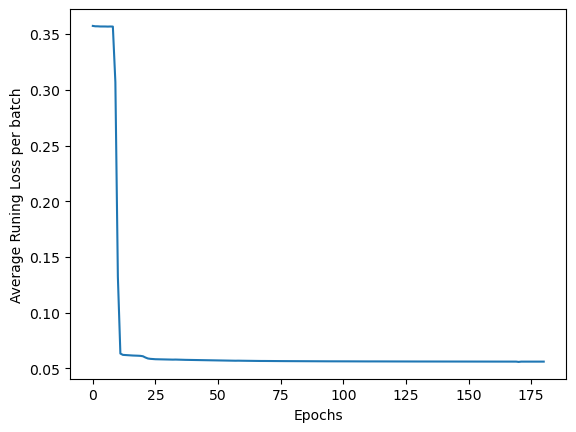

In [45]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [46]:
torch.save(final_model, 'model_100206_8g_03.pt')